In [1]:
import torch
import torch.nn.functional as F

import random
import matplotlib.pyplot as plt

## E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [2]:
names = open("video_2_dependencies/names.txt").read().splitlines()

In [3]:
print(names[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
chars = ["."]  + sorted(list(set("".join(names))))
stoi = {char:idx for idx, char in enumerate(chars)}
itos = {idx:char for char, idx in stoi.items()}

In [5]:
def build_dataset(words):
    X = []
    Y = []
    context_size = 3
    for word in words:
        window = [0]*context_size
        for ch in word + ".":
            x = window
            y = stoi[ch]
            X.append(x)
            Y.append(y)
            window = window[1:] + [y]
    return torch.tensor(X), torch.tensor(Y)

In [6]:
n1 = int(len(names) * 0.8)
n2 = int(len(names) * 0.9)

random.seed(42)
random.shuffle(names)

print(names[:10])

x_tr, y_tr = build_dataset(names[:n1])
x_val, y_val = build_dataset(names[n1:n2])
x_test, y_test = build_dataset(names[n2:])

['yuheng', 'diondre', 'xavien', 'jori', 'juanluis', 'erandi', 'phia', 'samatha', 'phoenix', 'emmelynn']


In [7]:
len(x_tr), len(x_val), len(x_test)

(182625, 22655, 22866)

In [8]:
g = torch.Generator().manual_seed(2147483647)

In [62]:
class Linear():
    def __init__(self, fan_in, fan_out, keep_bias = True):
        self.w = torch.randn(size = (fan_in, fan_out), generator = g) /(fan_in**0.5)*0
        self.b = torch.zeros(fan_out) if keep_bias == True else None
    
    def __call__(self, x):
        self.out = x @ self.w
        if self.b is None:
            return self.out
        else:
            self.out += self.b
            return self.out
        
    def parameters(self):
        return [self.w] if self.b is None else [self.w, self.b]

In [63]:
class tanh():
    def __init__(self):
        pass

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [64]:
g = torch.Generator().manual_seed(2147483647)
embed_dim = 10
fan_in = 3*10
fan_out = 100

C = torch.randn((27, embed_dim), generator = g)

layers = [Linear(fan_in, fan_out), tanh(),
        Linear(fan_out, fan_out), tanh(),
        Linear(fan_out, fan_out), tanh(),
        Linear(fan_out, fan_out), tanh(),
        Linear(fan_out, fan_out), tanh(),
        Linear(fan_out, 27),
        ]
with torch.no_grad():
        layers[-1].w.data *= 0.1
        for layer in layers[:-1]:
                if isinstance(layer, Linear):
                        layer.w.data *= 5/3

parameters = [C] + [params for layer in layers for params in layer.parameters()]

for param in parameters:
        param.requires_grad = True

In [65]:
parameters

[tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
          -2.9644e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01],
         [-4.7125e-01,  7.8682e-01, -3.2844e-01, -4.3297e-01,  1.3729e+00,
           2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4040e-01],
         [ 9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0731e-02,
           2.4968e+00,  2.4448e+00, -6.7006e-01, -1.2199e+00,  3.0314e-01],
         [-1.0725e+00,  7.2762e-01,  5.1114e-02,  1.3095e+00, -8.0220e-01,
          -8.5042e-01, -1.8068e+00,  1.2523e+00, -1.2256e+00,  1.2165e+00],
         [-9.6478e-01, -2.3211e-01, -3.4762e-01,  3.3244e-01, -1.3263e+00,
           1.1224e+00,  5.9641e-01,  4.5846e-01,  5.4011e-02, -1.7400e+00],
         [ 1.1560e-01,  8.0319e-01,  5.4108e-01, -1.1646e+00,  1.4756e-01,
          -1.0006e+00,  3.8012e-01,  4.7328e-01, -9.1027e-01, -7.8305e-01],
         [ 1.3506e-01, -2.1161e-01, -1.0406e+00, -1.5367e+00,  9.3743e-01,
          -8.8303e-

In [66]:
epochs = 200000
lossi = []
stepsi = []
u = []


for i in range(epochs):
    ui = []
    bidx = torch.randint(0, len(x_tr), (1,), generator = g)
    xtr_b, ytr_b = x_tr[bidx], y_tr[bidx]
    x = C[xtr_b]
    x = x.view(len(xtr_b), -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, ytr_b)

    for param in parameters:
        param.grad = None    
    
    for layer in layers:
        layer.out.retain_grad()

    loss.backward()

    lr = 0.1
    for param in parameters:
        param.data += -lr*param.grad
        ui.append((lr*param.grad.std()/param.data.std()).item())
 
    u.append(ui)

    if i % 1000 == 0:
        print(f"{i}: {loss.item()}")
    
    # if i == 1000:
    #     break
    break

0: 3.295836925506592


tensor(0.) tensor(0.)
tensor(0.)
tensor(0.) tensor(0.)
tensor(0.)
tensor(0.) tensor(0.)
tensor(0.)
tensor(0.) tensor(0.)
tensor(0.)
tensor(0.) tensor(0.)
tensor(0.)


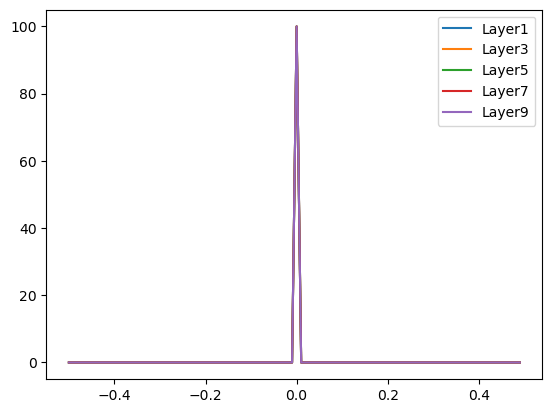

In [68]:
with torch.no_grad():
    for i, layer in enumerate(layers):
        if isinstance(layer, tanh):
            print(layer.out.mean(), layer.out.std())
            values = torch.histogram(layer.out, 100, density = True)
            print(torch.sum(torch.abs(layer.out.view(-1)) >= 0.97)/len(layer.out.view(-1)))
            plt.plot(values[1][:-1], values[0], label = f"Layer{i}")
    plt.legend()
    plt.show()

tensor(0.) tensor(0.)
tensor(0.) tensor(0.)
tensor(0.) tensor(0.)
tensor(0.) tensor(0.)
tensor(0.) tensor(0.)
tensor(0.) tensor(0.)


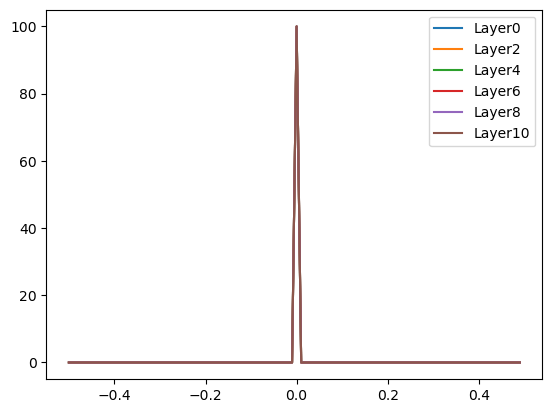

In [69]:
with torch.no_grad():
    for i, layer in enumerate(layers):
        if isinstance(layer, Linear):
            print(layer.out.mean(), layer.out.std())
            values = torch.histogram(layer.out, 100, density = True)
            plt.plot(values[1][:-1], values[0], label = f"Layer{i}")
    plt.legend()
    plt.show()

tensor(0.) tensor(0.)
tensor(0.) tensor(0.)
tensor(0.) tensor(0.)
tensor(0.) tensor(0.)
tensor(0.) tensor(0.)


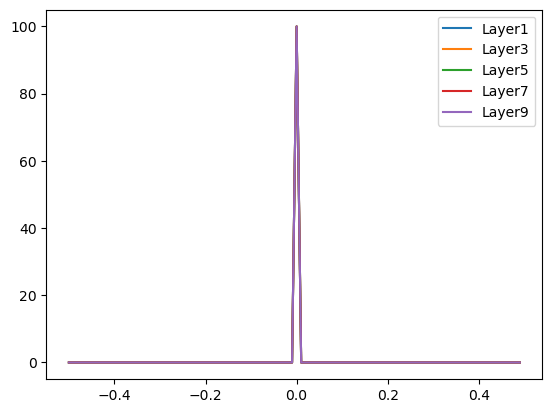

In [70]:
with torch.no_grad():
    for i, layer in enumerate(layers):
        if isinstance(layer, tanh):
            print(layer.out.grad.mean(), layer.out.grad.std())
            values = torch.histogram(layer.out.grad, 100, density = True)
            plt.plot(values[1][:-1], values[0], label = f"Layer{i}")
    plt.legend()
    plt.show()
                

tensor(0.)
tensor(0.)
tensor(nan)
tensor(0.)
tensor(0.)
tensor(nan)
tensor(0.)
tensor(0.)
tensor(nan)
tensor(0.)
tensor(0.)
tensor(nan)
tensor(0.)
tensor(0.)
tensor(nan)


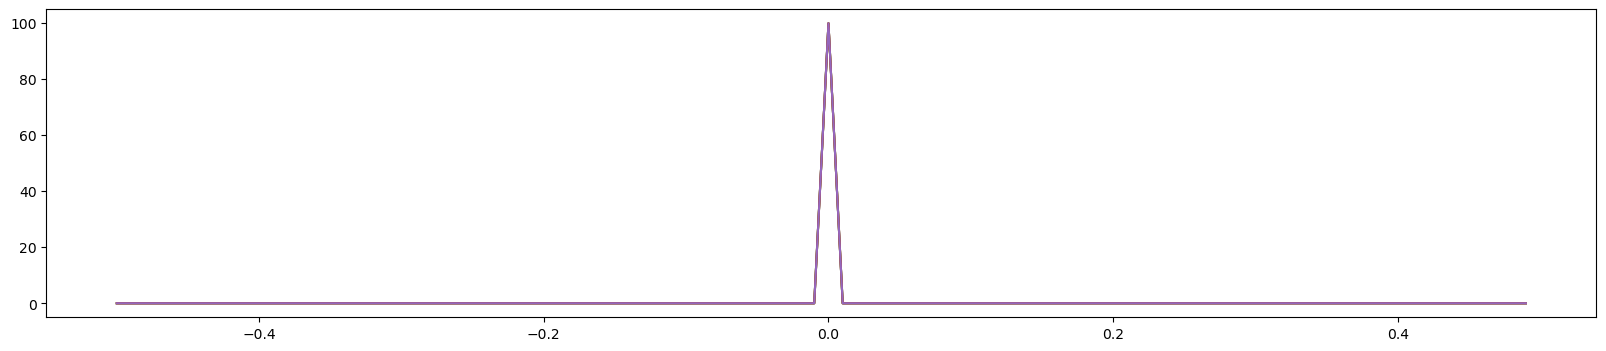

In [71]:
plt.figure(figsize = (20, 4))
#Without output layer
with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            param_of_interest = layer.parameters()[0] #ignoring b, focusing on w
            print(torch.mean(param_of_interest.grad))
            print(torch.std(param_of_interest.grad))
            g_to_d = param_of_interest.grad.std()/param_of_interest.data.std()
            print(torch.mean(g_to_d))
            values = torch.histogram(param_of_interest.grad, 100, density = True)
            plt.plot(values[1][:-1], values[0])

tensor(0.)
tensor(0.)
tensor(nan)
tensor(0.)
tensor(0.)
tensor(nan)
tensor(0.)
tensor(0.)
tensor(nan)
tensor(0.)
tensor(0.)
tensor(nan)
tensor(0.)
tensor(0.)
tensor(nan)
tensor(0.)
tensor(0.)
tensor(nan)


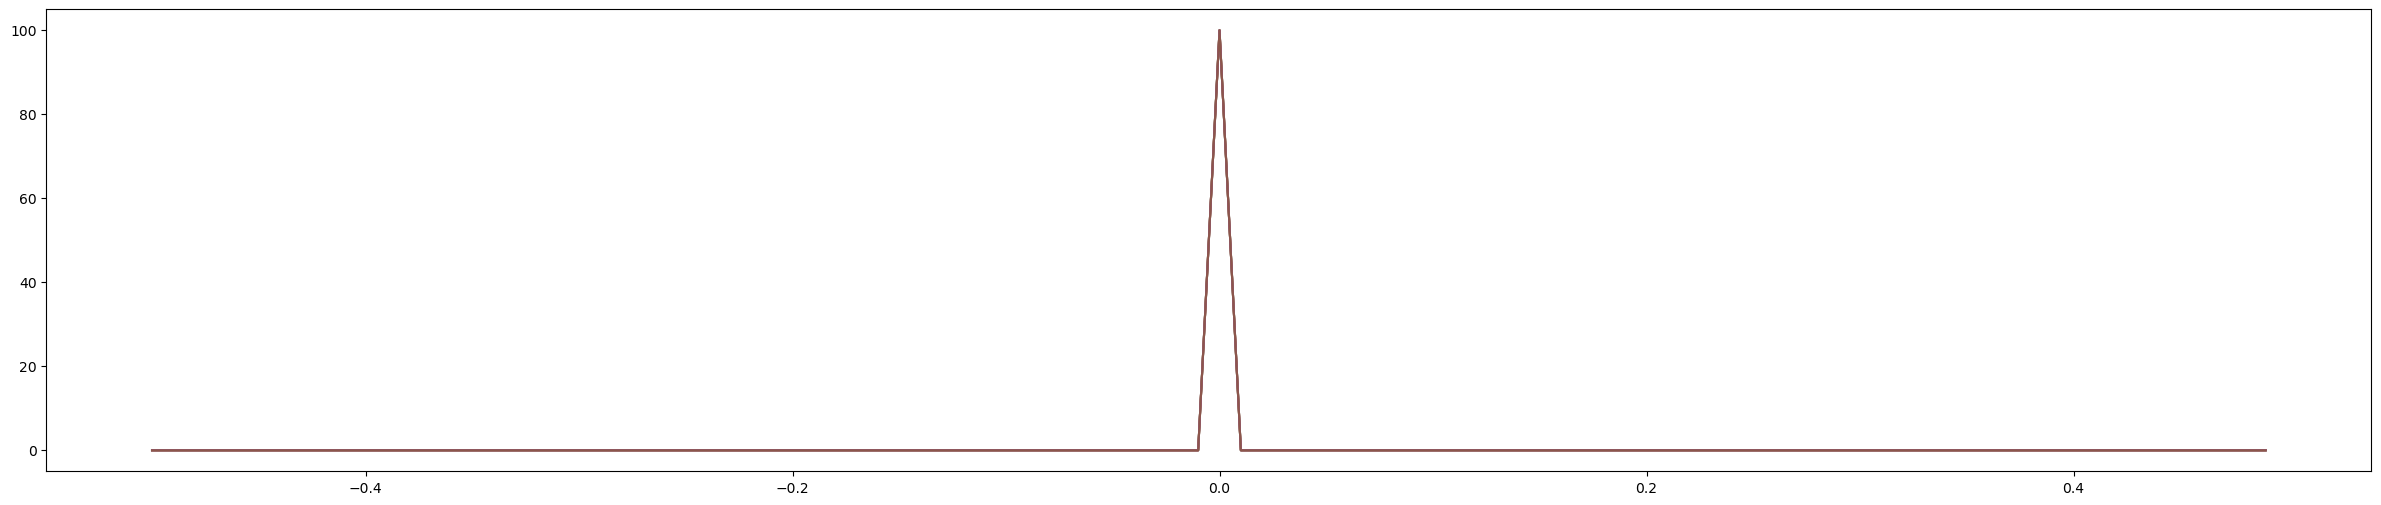

In [72]:
plt.figure(figsize = (30, 6))
#With output layer, focus on W
with torch.no_grad():
    for layer in layers:
        if isinstance(layer, Linear):
            param_of_interest = layer.parameters()[0] #ignoring b, focusing on w
            print(torch.mean(param_of_interest.grad))
            print(torch.std(param_of_interest.grad))
            g_to_d = param_of_interest.grad.std()/param_of_interest.data.std()
            print(torch.mean(g_to_d))
            values = torch.histogram(param_of_interest.grad, 100, density = True)
            plt.plot(values[1][:-1], values[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor(0.)
tensor(0.)
tensor(nan)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor(0.)
tensor(0.)
tensor(nan)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

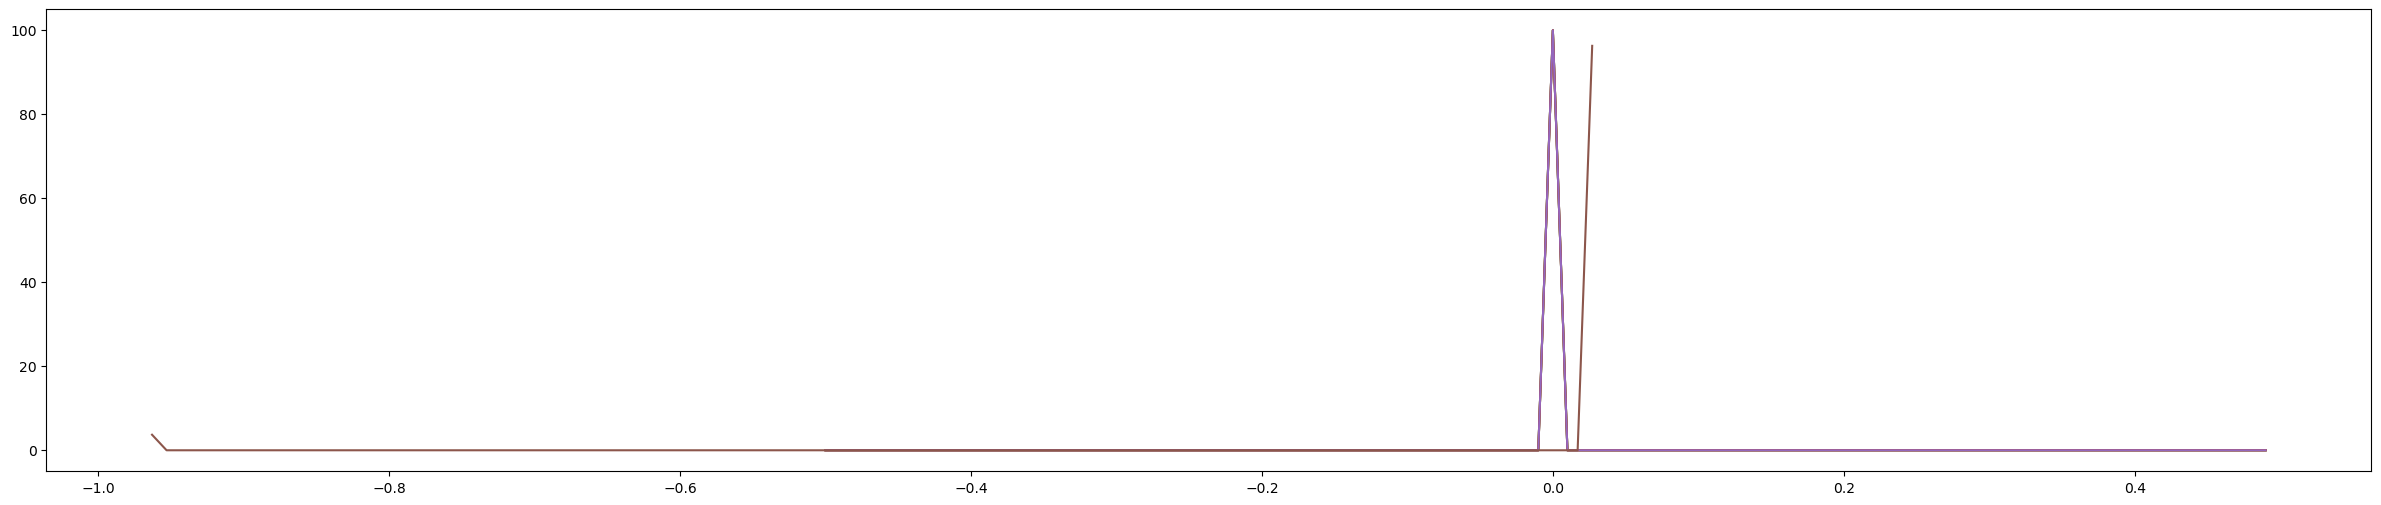

In [73]:
plt.figure(figsize = (30, 6))
#With output layer, focus on biases
with torch.no_grad():
    for layer in layers:
        if isinstance(layer, Linear):
            param_of_interest = layer.parameters()[1] #ignoring w, focusing on b
            print(param_of_interest.grad)
            print(torch.mean(param_of_interest.grad))
            print(torch.std(param_of_interest.grad))
            g_to_d = param_of_interest.grad.std()/param_of_interest.data.std()
            print(torch.mean(g_to_d))
            values = torch.histogram(param_of_interest.grad, 100, density = True)
            plt.plot(values[1][:-1], values[0])

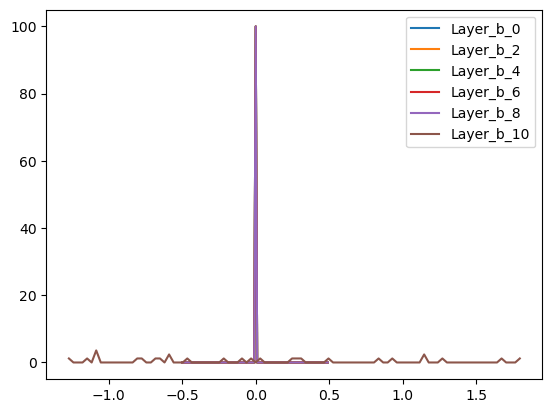

In [22]:
""" Final confirmation bias units have non-zero outputs """
#LOOKING as biases
with torch.no_grad():
    for i, layer in enumerate(layers):
        if isinstance(layer, Linear):
            value = torch.histogram(layer.parameters()[1].data, 100, density = True)
            plt.plot(value[1][:-1], value[0], label = f"Layer_b_{i}")
    plt.legend()
    plt.show()

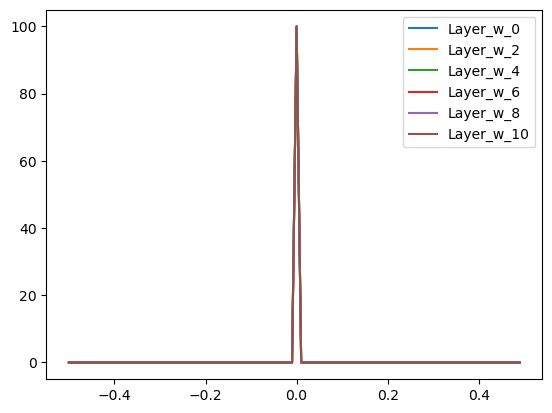

In [23]:
#Looking at weights
with torch.no_grad():
    for i, layer in enumerate(layers):
        if isinstance(layer, Linear):
            value = torch.histogram(layer.parameters()[0].data, 100, density = True)
            plt.plot(value[1][:-1], value[0], label = f"Layer_w_{i}")
    plt.legend()
    plt.show()

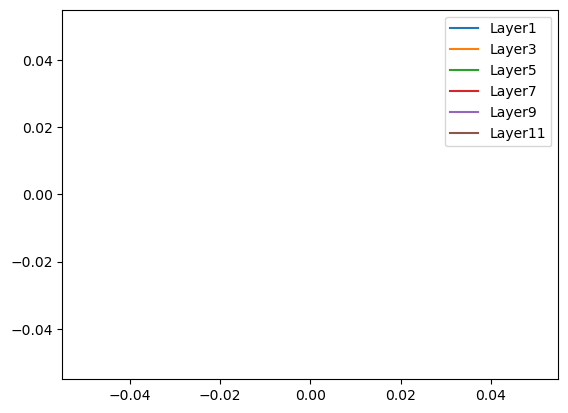

In [26]:
import numpy as np
for idx, p in enumerate(parameters[1:]):
    if p.ndim == 2:
        updates = [np.log(ui[1:][idx]) for ui in u]
        plt.plot(np.arange(len(updates)), updates, label = f"Layer{idx +1}")
plt.legend()
plt.show()

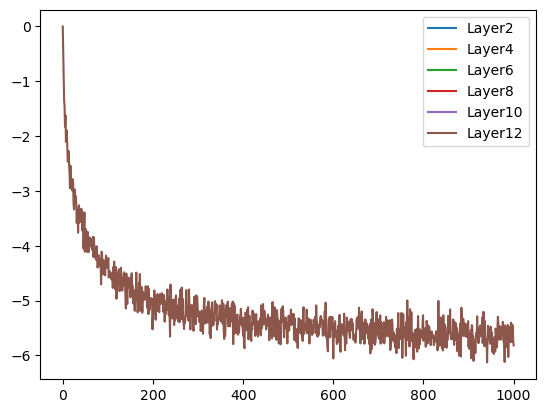

In [27]:
for idx, p in enumerate(parameters[1:]):
    if p.ndim == 1:
        updates = [np.log(ui[1:][idx]) for ui in u]
        plt.plot(np.arange(len(updates)), updates, label = f"Layer{idx +1}")
plt.legend()
plt.show()

In [28]:
np.log(np.exp(-2))

-2.0

What is happening is that only the biases of the final output layer are updating, as it has non-zero gradient, whereas the remaining weights and biases througout the model, get 0 gradient and thus do not uo=pdate

Note: The biases corresponding to wrong class get a gradient update of 1/n, wheras the bias for correct class gets an update for -(n-1)/n

Check out PDF in Video_4 extras for hand derivation showing an example of this for forward and backward pass

## E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [30]:
class BatchNorm1D():
    def __init__(self, fan_in, momentum = 0.01):
        self.gamma = torch.ones(fan_in)
        self.beta = torch.zeros(fan_in)
 
        self.running_mean = torch.zeros(fan_in)
        self.running_var = torch.ones(fan_in)

        self.momentum = momentum

    def __call__(self, x, is_training = True):
        if is_training:
            self.batch_mean = x.mean(0, keepdim = True)
            self.batch_var = x.var(0, keepdim = True)
        else:
            self.batch_mean = self.running_mean
            self.running_var = self.running_var

        x = (x - self.batch_mean)/(self.running_var**0.5)
        self.out = self.gamma*x + self.beta

        with torch.no_grad():
            if is_training:
                self.running_mean = self.running_mean*(1-self.momentum) + self.batch_mean*self.momentum
                self.running_var = self.running_var*(1-self.momentum) + self.batch_var*self.momentum
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [31]:
g = torch.Generator().manual_seed(2147483647)
embed_dim = 10
fan_in = 3*10
fan_out = 100

C = torch.randn((27, embed_dim), generator = g)

layers = [Linear(fan_in, fan_out, keep_bias = False), BatchNorm1D(fan_out), tanh(),
        Linear(fan_out, fan_out, keep_bias = False), BatchNorm1D(fan_out), tanh(),
        Linear(fan_out, 27,keep_bias = False),  BatchNorm1D(27),
        ]
with torch.no_grad():
        layers[-1].gamma.data *= 0.1
        for layer in layers[:-1]:
                if isinstance(layer, Linear):
                        layer.w.data *= 5/3

parameters = [C] + [params for layer in layers for params in layer.parameters()]

print(sum([param.nelement() for param in parameters]))

for param in parameters:
        param.requires_grad = True

16424


In [32]:
epochs = 200000
lossi = []
stepsi = []
u = []


for i in range(epochs):
    ui = []
    bidx = torch.randint(0, len(x_tr), (32,), generator = g)
    xtr_b, ytr_b = x_tr[bidx], y_tr[bidx]
    x = C[xtr_b]
    x = x.view(len(xtr_b), -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, ytr_b)

    for param in parameters:
        param.grad = None    
    
    for layer in layers:
        layer.out.retain_grad()

    loss.backward()

    lr = 0.1
    for param in parameters:
        param.data += -lr*param.grad
        ui.append((lr*param.grad.std()/param.data.std()).item())
 
    u.append(ui)

    if i % 1000 == 0:
        print(f"{i}: {loss.item()}")
    

0: 3.3127994537353516
1000: 2.761417865753174
2000: 2.686936140060425
3000: 2.4539268016815186
4000: 2.34627628326416
5000: 2.040186882019043
6000: 2.438401937484741
7000: 2.4583873748779297
8000: 1.7302886247634888
9000: 2.230905771255493
10000: 2.6783132553100586
11000: 2.08998703956604
12000: 2.1022286415100098
13000: 2.396470546722412
14000: 2.101783514022827
15000: 2.119933843612671
16000: 2.179054021835327
17000: 2.270033597946167
18000: 2.526442766189575
19000: 2.6094796657562256
20000: 2.3398661613464355
21000: 2.293903350830078
22000: 2.0501694679260254
23000: 2.3225419521331787
24000: 2.010230541229248
25000: 1.9874509572982788
26000: 2.194842576980591
27000: 2.1765973567962646
28000: 2.2638320922851562
29000: 2.1202943325042725
30000: 2.2454469203948975
31000: 2.28895902633667
32000: 2.0406100749969482
33000: 2.321507453918457
34000: 1.997817039489746
35000: 1.8249220848083496
36000: 2.10487699508667
37000: 2.1759512424468994
38000: 2.167945384979248
39000: 1.897653579711914

In [33]:
with torch.no_grad():
    x = C[x_tr]
    x = x.view(len(x_tr), -1)
    for layer in layers:
        if isinstance(layer, BatchNorm1D):
            x = layer(x, is_training = False)
        else:
            x = layer(x)
    loss = F.cross_entropy(x, y_tr)
    print(loss)

tensor(2.0646)


In [34]:
with torch.no_grad():
    print(layers[:3][1].parameters()[0] * ((C[x_tr].view(len(x_tr), -1) @ layers[:3][0].parameters()[0] - layers[:3][1].running_mean)/((layers[:3][1].running_var)**0.5)) + layers[:3][1].parameters()[1])

tensor([[ 0.5511, -0.0197, -0.3933,  ...,  0.1438, -0.5377, -0.3649],
        [-0.9479,  0.5139,  1.2259,  ...,  0.8720, -2.6587,  0.1135],
        [-0.1249,  1.0385, -0.6062,  ..., -2.6998, -0.9271,  0.1928],
        ...,
        [ 3.6683,  3.2389, -1.1988,  ..., -0.3514, -1.0796,  0.1267],
        [-1.2268, -2.2297,  1.9870,  ..., -1.3354,  4.3312,  2.4772],
        [-1.2816,  0.4346, -1.6841,  ..., -1.0166, -1.6981, -3.6729]])


In [35]:
with torch.no_grad():
    part_a = (layers[:3][0].parameters()[0]*layers[:3][1].parameters()[0])/((layers[:3][1].running_var)**0.5)
    part_b = -(layers[:3][1].running_mean * layers[:3][1].parameters()[0])/((layers[:3][1].running_var)**0.5) + layers[:3][1].parameters()[1]
    print(C[x_tr].view(len(x_tr), -1) @ part_a + part_b)
    print("(input @ ((w1*gamma)/(var**0.5))) - (((mean*gamma)/(var**0.5)) + beta)")

tensor([[ 0.5511, -0.0197, -0.3933,  ...,  0.1438, -0.5377, -0.3649],
        [-0.9479,  0.5139,  1.2259,  ...,  0.8720, -2.6587,  0.1135],
        [-0.1249,  1.0385, -0.6062,  ..., -2.6998, -0.9271,  0.1928],
        ...,
        [ 3.6683,  3.2389, -1.1988,  ..., -0.3514, -1.0796,  0.1267],
        [-1.2268, -2.2297,  1.9870,  ..., -1.3354,  4.3312,  2.4772],
        [-1.2816,  0.4346, -1.6841,  ..., -1.0166, -1.6981, -3.6729]])
(input @ ((w1*gamma)/(var**0.5))) - (((mean*gamma)/(var**0.5)) + beta)


In [40]:
g = torch.Generator().manual_seed(2147483647)
embed_dim = 10
fan_in = 3*10
fan_out = 100

fold_in_BN_layers = [Linear(fan_in, fan_out), tanh(),
        Linear(fan_out, fan_out), tanh(),
        Linear(fan_out, 27),
        ]

layers_to_alter = [0,2,4]
change_idx = 0

with torch.no_grad():
    for i in range(0, len(layers), 3):
        W2 = (layers[i].parameters()[0]*layers[i+1].parameters()[0])/((layers[i+1].running_var)**0.5)
        b2 = -(layers[i+1].running_mean * layers[i+1].parameters()[0])/((layers[i+1].running_var)**0.5) + layers[i+1].parameters()[1]
        fold_in_BN_layers[layers_to_alter[change_idx]].parameters()[0].data = W2
        fold_in_BN_layers[layers_to_alter[change_idx]].parameters()[1].data = b2
        change_idx +=1

fold_in_BN_parameters = [C] + [params for layer in fold_in_BN_layers for params in layer.parameters()]

print(sum([param.nelement() for param in fold_in_BN_parameters]))

for param in fold_in_BN_parameters:
        param.requires_grad = True

16197


In [41]:
with torch.no_grad():
    x = C[x_tr]
    x = x.view(len(x_tr), -1)
    for layer in fold_in_BN_layers:
            x = layer(x)
    loss = F.cross_entropy(x, y_tr)
    print(loss)

tensor(2.0646)
